In [40]:
import matplotlib.pyplot as plt
from funcs import *
import os

os.chdir(R'C:\Users\adria\OneDrive\Pulpit\studia_foldery\teledetekcja')

In [41]:
cir_raster = r"TIFs\CIR_2015.tif"
cir_dataset = read_spatial_raster(cir_raster)

rgb_raster = r"TIFs\RGB_2015.tif"
rgb_dataset = read_spatial_raster(rgb_raster)

c:\Users\adria\anaconda3\envs\teledetekcja\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: CIR_2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)
c:\Users\adria\anaconda3\envs\teledetekcja\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: RGB_2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)


In [42]:
band_nir = cir_dataset.GetRasterBand(1)
array_nir = band_nir.ReadAsArray()
array_nir = np.copy(array_nir)

band_red = cir_dataset.GetRasterBand(2)
array_red = band_red.ReadAsArray()
array_red = np.copy(array_red)

band_green = cir_dataset.GetRasterBand(3)
array_green = band_green.ReadAsArray()
array_green = np.copy(array_green)

band_blue = rgb_dataset.GetRasterBand(3)
array_blue = band_blue.ReadAsArray()
array_blue = np.copy(array_blue)

In [43]:
ids = np.array([7, 0, 3])

vector_features = gpd.read_file(R"budynki\budynki.shp")

features = reproject_geodataframe(vector_features, cir_dataset.GetProjection())
features = convert_to_pixel_system(features, cir_dataset.GetGeoTransform())

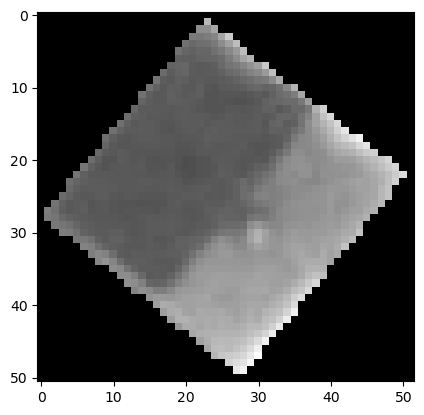

[113  87  87 ... 151 143 150] 48 157 77.2828999211978


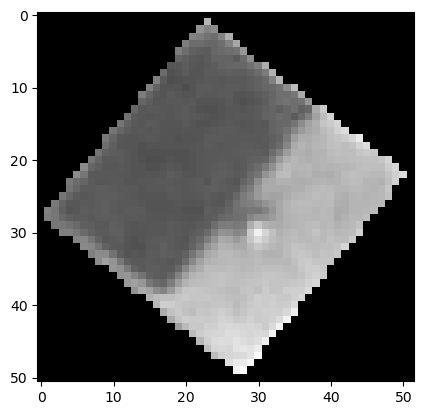

[ 92  75  67 ... 126 125 130] 40 131 70.44365642237983


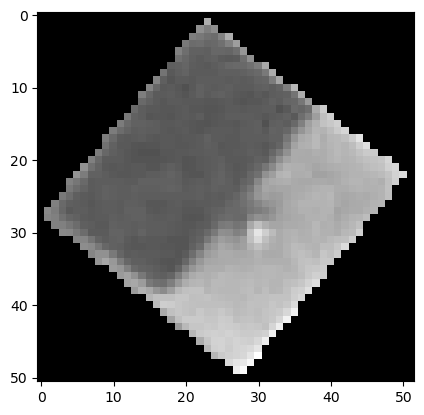

[ 91  75  66 ... 130 125 131] 43 134 71.22695035460993


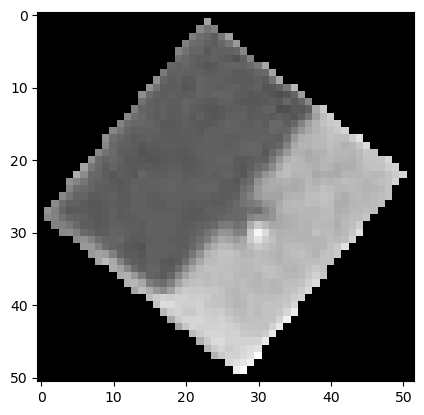

[ 76  64  54 ... 113 112 119] 37 120 65.39322301024428


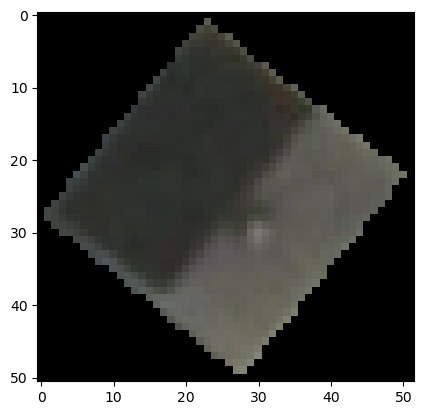

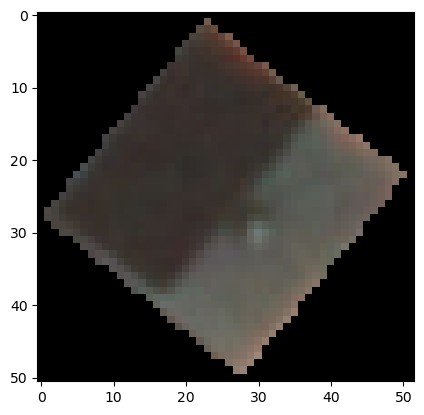

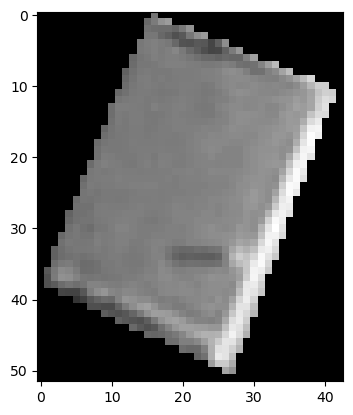

[ 86  77  90 ... 125 121 108] 39 187 101.36163265306122


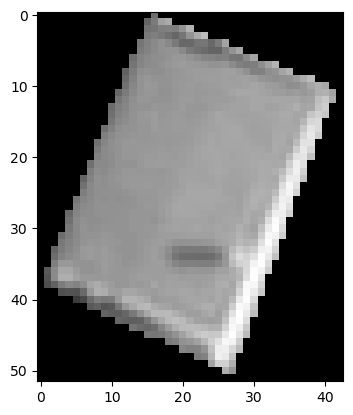

[ 88  80  98 ... 138 139 119] 47 203 127.01306122448979


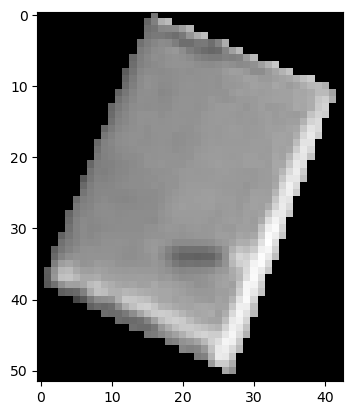

[100  87 109 ... 147 143 125] 60 217 132.78448979591838


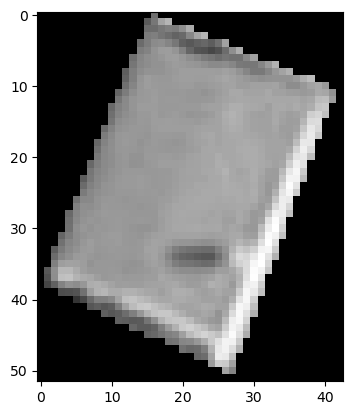

[ 89  73  96 ... 130 132 107] 43 205 128.09142857142857


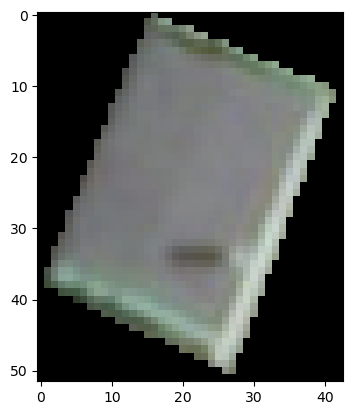

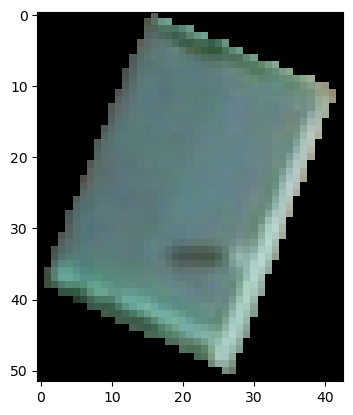

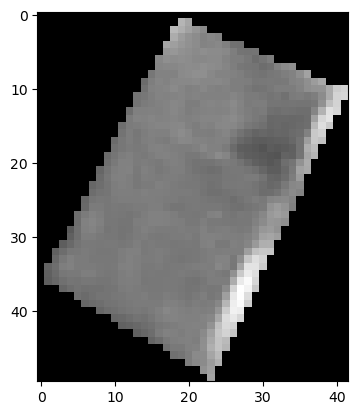

[126 116 129 ... 101 111 114] 59 178 90.41953488372093


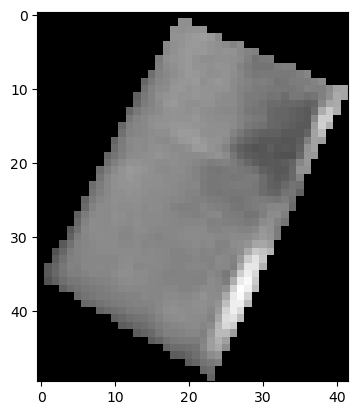

[106 106 107 ...  77  81  74] 60 189 98.90325581395349


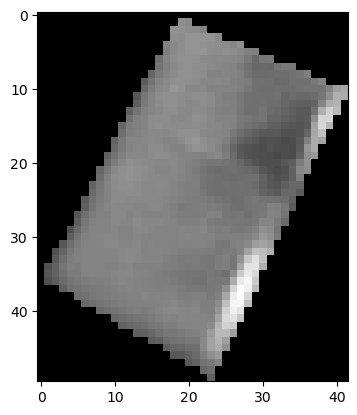

[108 105 110 ...  77  83  74] 55 193 96.62139534883721


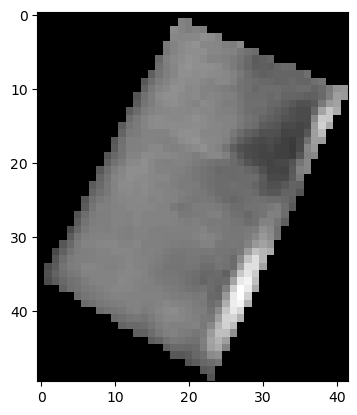

[ 97  94 104 ...  66  70  62] 44 191 92.05953488372093


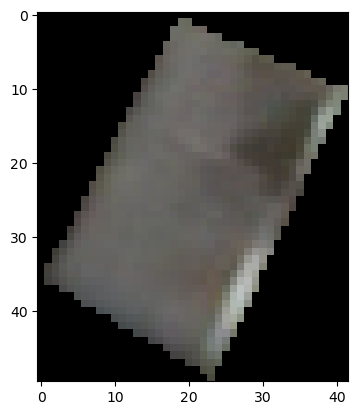

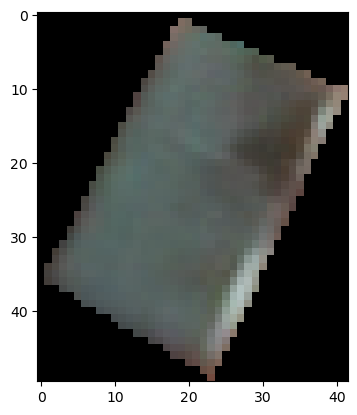

In [44]:
for id in ids:
    example_feature = features.iloc[id]
    example_feature = example_feature['geometry']

    bounds = example_feature.bounds
    bounds = np.float64(bounds)

    bounds[:2] = np.floor(bounds[:2])
    bounds[2:] = np.ceil(bounds[2:])
    bounds = np.int64(bounds)

    fragment_nir = array_nir[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]

    fragment_red = array_red[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]

    fragment_green = array_green[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]

    fragment_blue = array_blue[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]

    plt.imsave(f"img\\nir_budynek{id}.png", fragment_nir, cmap='gray')
    plt.imsave(f"img\\red_budynek{id}.png", fragment_red, cmap='gray')
    plt.imsave(f"img\\green_budynek{id}.png", fragment_green, cmap='gray')
    plt.imsave(f"img\\blue_budynek{id}.png", fragment_blue, cmap='gray')

    feature_in_fragment_frame = shapely.affinity.translate(example_feature, -bounds[0], -bounds[1])

    from rasterio.features import rasterize

    no_data_mask = rasterize([feature_in_fragment_frame], fragment_nir.shape)
    no_data_mask = np.bool_(no_data_mask)
    no_data_mask = ~no_data_mask    # Rasterio puts True inside polygon
    masked_fragment = np.copy(fragment_nir)
    masked_fragment[no_data_mask] = 0
    plt.imshow(masked_fragment, cmap='gray')
    plt.show()

    pixel_values = fragment_nir[~no_data_mask]  # Select just valid pixels
    print(pixel_values, pixel_values.min(), pixel_values.max(), pixel_values.mean())


    no_data_mask = rasterize([feature_in_fragment_frame], fragment_red.shape)
    no_data_mask = np.bool_(no_data_mask)
    no_data_mask = ~no_data_mask    # Rasterio puts True inside polygon

    masked_fragment = np.copy(fragment_red)
    masked_fragment[no_data_mask] = 0
    plt.imshow(masked_fragment, cmap='gray')
    plt.show()

    pixel_values = fragment_red[~no_data_mask]  # Select just valid pixels
    print(pixel_values, pixel_values.min(), pixel_values.max(), pixel_values.mean())

    masked_fragment = np.copy(fragment_green)
    masked_fragment[no_data_mask] = 0
    plt.imshow(masked_fragment, cmap='gray')
    plt.show()

    pixel_values = fragment_green[~no_data_mask]  # Select just valid pixels
    print(pixel_values, pixel_values.min(), pixel_values.max(), pixel_values.mean())

    masked_fragment = np.copy(fragment_blue)
    masked_fragment[no_data_mask] = 0
    plt.imshow(masked_fragment, cmap='gray')
    plt.show()

    pixel_values = fragment_blue[~no_data_mask]  # Select just valid pixels
    print(pixel_values, pixel_values.min(), pixel_values.max(), pixel_values.mean())

    rgb = np.dstack([fragment_red, fragment_green, fragment_blue])
    rgb[no_data_mask] = 0
    plt.imshow(rgb, cmap='gray')
    plt.show()

    irgb = np.dstack([fragment_nir, fragment_green, fragment_blue])
    irgb[no_data_mask] = 0
    plt.imshow(irgb, cmap='gray')
    plt.show()